# Drug Classification using RandomForest Classifier, Logistic Regression & Gaussian Naive Bayes.

This notebook aims at utilizing the antigranular environment to draw inference on the 'Drug' dataset including visualizing the data - classifying into drug(x...y) classes. Based on factors like 'Age', 'Sex', 'BP' (blood pressure) etc. we try to determine which drug is suitable for the patient.

To facilitate this, we've used VSCode, but you may choose your own tool/platform to work on a jupyter notebook.

## Getting Started : Setting up the environment.

Login and load the dataset.

In [1]:
#DEV
import antigranular as ag
session = ag.login(<client_id>,<client_secret>, dataset = "Drug Dataset")

Loading dataset "Drug Dataset" to the kernel...
Dataset "Drug Dataset" loaded to the kernel as drug_dataset
Connected to Antigranular server session id: 94e438dc-8bca-4518-89ac-1457647b9e86, the session will time out if idle for 60 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


Verify that the session object is in the local runtime.

In [2]:
session.session_id

'94e438dc-8bca-4518-89ac-1457647b9e86'

The session object, that we just logged in against, comes with more than just the session_id. Use the dot operator and let your intellisense do the rest. Seek and ye shall find. ;)

### Segregate the dataset into train_x, train_y, and test_x.

As mentioned above just after the login, 'Dataset "Drug Dataset" loaded to the kernel as drug_dataset'. Thanks to the team - now the dataset comes pre-loaded and all I have to do is fetch the train_x, train_y and test_x from it.

Nice try, but 'test_y' is only for our databases.

In [50]:
%%ag
train_x = drug_dataset['train_x']
train_y = drug_dataset['train_y']
test_x = drug_dataset['test_x']

#### Export and verify test_x.

Another cool trick - use __export__ to bring your AG variables to life. Something like this.

In [51]:
%%ag
from ag_utils import export
export(test_x, 'test_x')

Setting up exported variable in local environment: test_x


In [52]:
test_x.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,49,M,HIGH,NORMAL,6.269
1,64,F,LOW,NORMAL,25.741
2,60,M,HIGH,NORMAL,8.621
3,74,M,HIGH,NORMAL,15.436
4,39,M,HIGH,HIGH,9.664


Did I just extract the variable __test_x__ into my local runtime? Amazing!

## Data Pre-processing

### Get all column names & unique values.

If you just want to print something, given that it's not called 'peeking' into the private data. Let us do the job for you using __ag_print__. You wouldn't like to spend time using export here - time is money.

In [53]:
%%ag
ag_print(train_x.columns)
ag_print(train_y.columns)

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')
Index(['Drug'], dtype='object')



How do I know what data types are these columns? This is exactly how.

In [54]:
%%ag
ag_print(train_x.dtypes, train_y.dtypes)

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
dtype: object Drug    object
dtype: object



Independent variables - [ 'Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K' ] & Dependent variable - [ 'Drug' ]

And now we begin.

'Identifying the numerical columns and their range'

In [55]:
%%ag
ag_print(train_x.metadata)

{'Age': (15, 74), 'Na_to_K': (6.683, 38.247)}



'Getting unique values for each categorical column'

In [56]:
%%ag
import pandas as pd
test_x_dropped = test_x.drop(columns=['Age', 'Na_to_K'])
unique_values = {}
for col_name, col_data in test_x_dropped.items():
    unique_values[col_name] = col_data.unique()
ag_print(unique_values)

{'Sex': array(['M', 'F'], dtype=object), 'BP': array(['HIGH', 'LOW', 'NORMAL'], dtype=object), 'Cholesterol': array(['NORMAL', 'HIGH'], dtype=object)}



<div class="alert alert-block alert-info">
<b>Inference : </b>  
Numerical columns & their range
{'Age': (15, 74), 'Na_to_K': (6.683, 38.247)}
Categorical columns & their unique values
{'Sex': ['M', 'F'],
'BP': ['HIGH', 'LOW', 'NORMAL'], 
'Cholesterol': ['NORMAL', 'HIGH']}
</div>

### Univariate Analysis

#### 1. Age

'Minimum Age : 15
Maximum Age : 74'

'Distribution plot for Age'

In [57]:
%%ag
from ag_utils import export
Age_Hist = train_x['Age'].hist(eps=1.0, bins=40)
export(Age_Hist, 'Age_Hist')

Setting up exported variable in local environment: Age_Hist


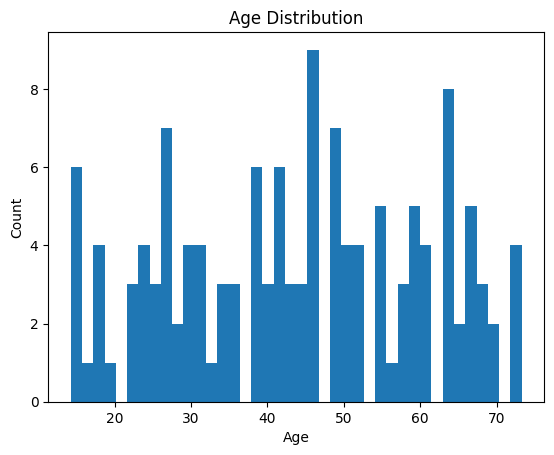

In [58]:
from matplotlib import pyplot as plt

dp_hist, dp_bins = Age_Hist
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.bar(dp_bins[:-1], dp_hist, width=dp_bins[1]-dp_bins[0])
plt.show()

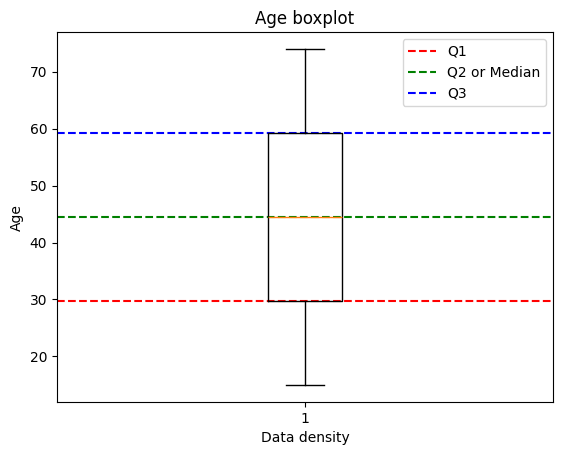

In [59]:
import numpy as np
fig, ax = plt.subplots()
quantiles = np.percentile(dp_bins, [25, 50, 75])
ax.axhline(quantiles[0], color='r', linestyle='dashed', label='Q1')
ax.axhline(quantiles[1], color='g', linestyle='dashed', label= 'Q2 or Median')
ax.axhline(quantiles[2], color='b', linestyle='dashed', label= 'Q3')
ax.legend()
ax.set_xlabel('Data density')
ax.set_ylabel('Age')
ax.set_title('Age boxplot')
ax.boxplot(dp_bins)
plt.show()

<div class="alert alert-block alert-success">
<b>Inference :</b> No outliers in the 'Age' column
</div>

#### 2. Sex

In [60]:
%%ag
age_encoding = {'M': 0, 'F': 1}
train_x['Sex'] = train_x['Sex'].map(age_encoding, output_bounds = (0,1))
test_x['Sex'] = test_x['Sex'].map(age_encoding)

In [61]:
%%ag
Sex_Hist = train_x['Sex'].hist(eps=1.0, bins= [0,1,2])
export(Sex_Hist, 'Sex_Hist')

Setting up exported variable in local environment: Sex_Hist


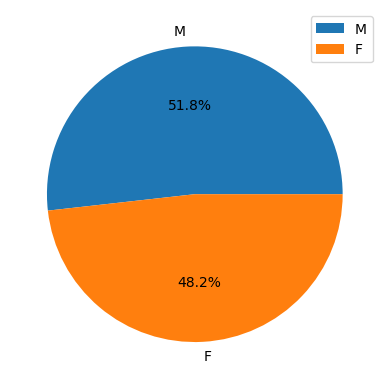

In [62]:
from matplotlib import pyplot as plt

chart, bins = Sex_Hist
labels = ['M', 'F']
plt.pie(chart, labels=labels, autopct='%1.1f%%')
plt.legend()
plt.show()

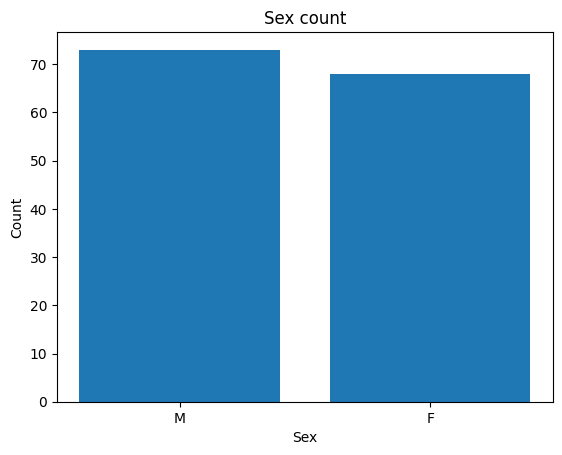

In [63]:
plt.bar(labels, chart)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex count')
plt.show()

<div class="alert alert-block alert-info">
<b>Inference : </b> 
Balanced data with 68 Females and 72 Males as per the mapping 
F : 0,
M : 1. 
</div>

#### 3. BP

Encoding Blood Pressure values

In [64]:
%%ag
blood_pressure_encoder = {'LOW': 0, 'NORMAL': 1, 'HIGH': 2}
train_x['BP'] = train_x['BP'].map(blood_pressure_encoder, output_bounds = (0, 2))
test_x['BP'] = test_x['BP'].map(blood_pressure_encoder)

In [65]:
%%ag
BP_Hist = train_x['BP'].hist(eps=1,bins=[0,1,2,3])
export(BP_Hist, 'BP_Hist')

Setting up exported variable in local environment: BP_Hist


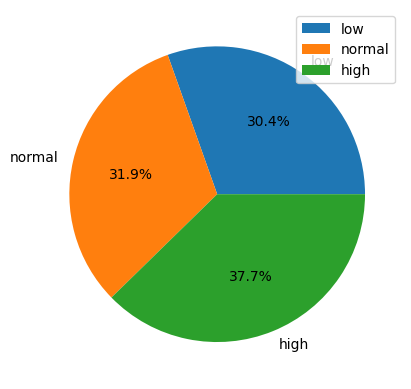

In [66]:
chart, bins = BP_Hist
labels = ['low', 'normal', 'high']
plt.pie(chart, labels=labels, autopct='%1.1f%%')
plt.legend()
plt.show()

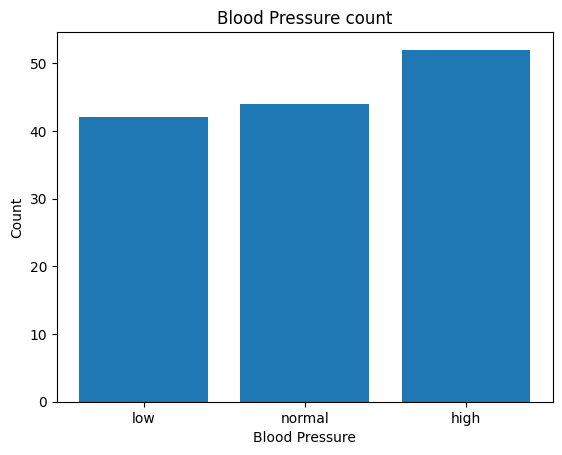

In [67]:
plt.bar(labels,chart)
plt.xlabel('Blood Pressure')
plt.ylabel('Count')
plt.title('Blood Pressure count')
plt.show()

<div class="alert alert-block alert-info">
<b>Inference : </b> Roughly equally balanced data with 43 LOW, 45 NORMAL and 54 HIGH Blood Pressures as per mapping
0: LOW
1: NORMAL 
2: HIGH
</div>

#### 4. Cholestrol

Encoding Cholestrol values.

In [68]:
%%ag
cholestrol_encoder = {'NORMAL': 0, 'HIGH': 1}
train_x['Cholesterol'] = train_x['Cholesterol'].map(cholestrol_encoder, output_bounds = (0, 1))
test_x['Cholesterol'] = test_x['Cholesterol'].map(cholestrol_encoder)

Generating Histogram for the data and exporting it.

In [69]:
%%ag
Cholesterol_Hist = train_x['Cholesterol'].hist(eps=1.0, bins= [0,1,2])
export(Cholesterol_Hist, 'Cholesterol_Hist')

Setting up exported variable in local environment: Cholesterol_Hist


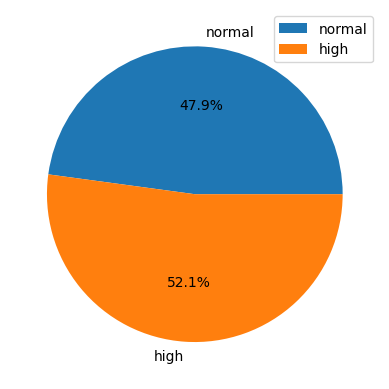

In [70]:
chart, bins = Cholesterol_Hist
labels = ['normal', 'high']
plt.pie(chart, labels=labels, autopct='%1.1f%%')
plt.legend()
plt.show()

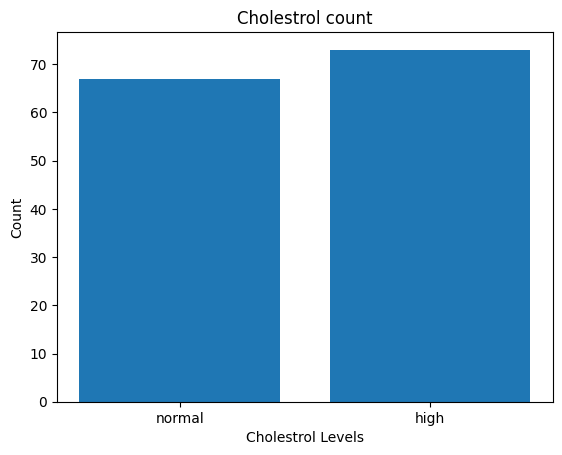

In [71]:
plt.bar(labels,chart)
plt.xlabel('Cholestrol Levels')
plt.ylabel('Count')
plt.title('Cholestrol count')
plt.show()


<div class="alert alert-block alert-info">
<b>Inference : </b> 65 Normal and 74 High Cholesterol values.
</div>

#### 5. Na_to_K

Generating Histogram for the data and exporting it.

In [72]:
%%ag
Nak_Hist = train_x['Na_to_K'].hist(eps=1.0, bins='auto')
export(Nak_Hist, 'Nak_Hist')

Setting up exported variable in local environment: Nak_Hist


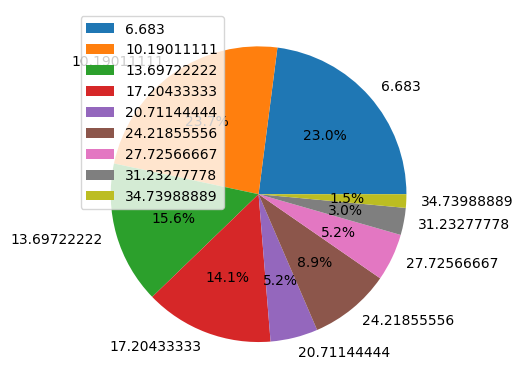

In [73]:
chart, bins = Nak_Hist
labels=[6.683, 10.19011111, 13.69722222, 17.20433333, 20.71144444, 24.21855556, 27.72566667, 31.23277778, 34.73988889]
plt.pie(chart, labels=labels, autopct='%1.1f%%')
plt.legend()
plt.show()

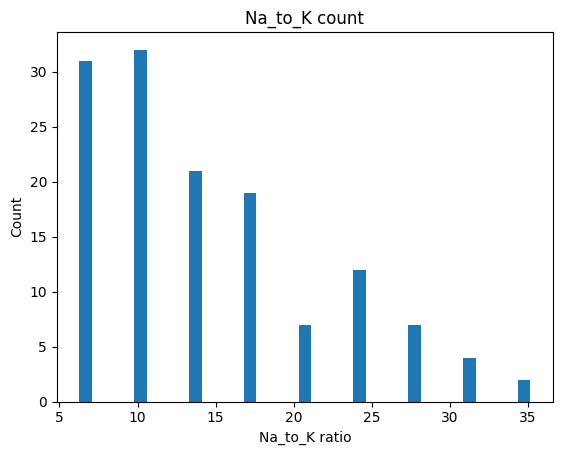

In [74]:
plt.bar(labels,chart)
plt.xlabel('Na_to_K ratio')
plt.ylabel('Count')
plt.title('Na_to_K count')
plt.show()

Inference : Most of the data has Na_to_K ratio below ~17

### Describing the DF

In [75]:
%%ag
ag_print(train_x.describe(eps=1))

              Age         Sex          BP  Cholesterol     Na_to_K
count  142.000000  142.000000  142.000000   142.000000  142.000000
mean    47.642873    0.404545    1.065103     0.966121   11.402106
std     28.239511    0.459865    0.803145     0.372515   14.128927
min     15.000000    0.000000    0.000000     0.000000    6.683000
25%     46.042014    0.080933    0.000000     0.868584   14.361093
50%     22.434774    0.880132    0.000000     0.384031   35.155114
75%     48.320249    0.973126    0.000000     0.455608    9.394863
max     49.085741    0.998749    1.491446     0.955651   25.019899



## Modeling & Fitting

RandomForestClassifier Model - Find upper and lower bounds and render model

In [76]:
%%ag
from op_diffprivlib import models
l_meta, r_meta = [], []
for l,r in train_x.metadata.values():
  l_meta.append(l)
  r_meta.append(r)
bounds = ( l_meta , r_meta ) # ([lower] , [upper])
model_RFC = models.RandomForestClassifier(n_estimators=100, epsilon = 20 , random_state=33 , bounds=bounds , classes=['drugA', 'drugB', 'drugC', 'drugX', 'DrugY'])

LogisticRegression Model - Find L2 Norm and render model

In [77]:
%%ag
train_x_2 = train_x ** 2
l_2_norm = train_x_2.sum(axis = 1) ** 0.5
l_2_norm = l_2_norm.quantile(1, eps=10)

model_LR = models.LogisticRegression(epsilon=20, data_norm=l_2_norm)

GaussianNB model - Define bounds and render model 

In [78]:
%%ag
model_GNB = models.GaussianNB(epsilon=20, bounds=bounds, random_state=33)

Fitting the models.

In [79]:
%%ag
model_RFC.fit(train_x, train_y)
model_LR.fit(train_x, train_y)
model_GNB.fit(train_x, train_y)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



## Predictions against test_x.

In [80]:
%%ag
rfc_pred = model_RFC.predict(test_x)
lr_pred = model_LR.predict(test_x)
gnb_pred = model_GNB.predict(test_x)

### Submission accuracy

There are 2 ways we can submit the predictions with AG - we will use both.

#### Way 1 : Using __submit_predictions__ function from the ag_utils library

RandomForest

In [109]:
%%ag
from ag_utils import submit_predictions
import pandas as pd
rfc_pred = pd.DataFrame(rfc_pred)
submit_predictions(rfc_pred)

score: {'leaderboard': 0.9435028522960844, 'logs': {'BIN_ACC': 0.6767745549206671, 'LIN_EPS': -0.33, 'MCC': 0.5967282973754174}}



LogisticRegression

In [105]:
%%ag
lr_pred = pd.DataFrame(lr_pred)
submit_predictions(lr_pred)

score: {'leaderboard': 1.011715647042734, 'logs': {'BIN_ACC': 0.7229179062148612, 'LIN_EPS': -0.33, 'MCC': 0.6187977408278729}}



Gaussian Naive Bayes

In [103]:
%%ag
gnb_pred = pd.DataFrame(gnb_pred)
submit_predictions(gnb_pred)

score: {'leaderboard': 1.0359585804218292, 'logs': {'BIN_ACC': 0.8659585804218293, 'LIN_EPS': -0.33, 'MCC': 0.5}}



#### Way 2 : By __exporting__ the predictions from AG variable into local runtime environment.

Use __export__ function to export variables into your local runtime, even your predictions. How cool is that?

In [84]:
%%ag
export(rfc_pred , "rfc_pred")
export(lr_pred, "lr_pred")
export(gnb_pred, "gnb_pred")

Setting up exported variable in local environment: rfc_pred
Setting up exported variable in local environment: lr_pred
Setting up exported variable in local environment: gnb_pred


Not only I have better control over my predictions in my local environment, but I also can pacify my overthinking by looking at it 100 times...

In [85]:
rfc_pred

,0
0,drugB
1,drugC
2,drugB
3,drugB
4,drugA
5,drugC
6,drugA
7,drugA
8,drugC
9,drugC


In [86]:
lr_pred

,0
0,drugA
1,drugX
2,drugA
3,drugA
4,drugA
5,drugA
6,drugB
7,DrugY
8,drugB
9,drugB


In [87]:
gnb_pred

,0
0,drugC
1,drugC
2,drugC
3,drugC
4,drugC
5,drugC
6,drugC
7,drugC
8,drugC
9,drugC


Wrapping predictions into a DataFrame - Since AG accepts pandas DataFrames as valid submissions, we will wrap the predictions inside a DF.

In [88]:
import pandas as pd

rfc_df = pd.DataFrame(rfc_pred)
lr_df = pd.DataFrame(lr_pred)
gnb_df = pd.DataFrame(gnb_pred)


LogisticRegression

In [89]:
session.submit_predictions(lr_df)

{'score': {'leaderboard': 0.9569387357192354,
  'logs': {'BIN_ACC': 0.6681409948913626,
   'LIN_EPS': -0.33,
   'MCC': 0.6187977408278729}}}

RandomForestClassifier

In [93]:
session.submit_predictions(rfc_df)

{'score': {'leaderboard': 1.0891417904927816,
  'logs': {'BIN_ACC': 0.8224134931173641,
   'LIN_EPS': -0.33,
   'MCC': 0.5967282973754174}}}

Gaussian Naive Bayes

In [91]:
session.submit_predictions(gnb_df)

{'score': {'leaderboard': 1.0542119610214522,
  'logs': {'BIN_ACC': 0.8842119610214522, 'LIN_EPS': -0.33, 'MCC': 0.5}}}

## Epsilon - How much did we use?

In [92]:
session.privacy_odometer()

{'total_epsilon_used': 66.0,
 'total_delta_used': 0.0,
 'library_costs': None,
 'dataset_costs': None}